In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

from utils.parse_pars import parse_pars
from spamm.run_spamm import spamm
import run_fe, run_nc, run_bc, run_hg
from utils.add_in_quadrature import add_in_quadrature
from spamm.analysis import plot_best_models
from spamm.Samples import Samples

import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
test = np.loadtxt("../data/HostModels/pickles_uk_6.ascii")
wave, flux = test[:, 0], test[:, 1]
print((flux.max() - flux.min())/2)
print(flux.min())

2.999770497e-08
1.49006e-12


In [3]:
# This should be a wavelength range from 1000-10,000A, every 0.5A
TEST_WL = parse_pars()["testing"]
# Create wavelength array from min, max and step values
WL = np.arange(TEST_WL["wl_min"], TEST_WL["wl_max"], TEST_WL["wl_step"])

# These values were picked by hand to provide the most realistic power law.
NC_PARAMS = {"wl": WL,
             "slope1": 2.3,
             "norm_PL": 5e-15,
             "broken_pl": False}

# The normalizations are drawn from a gaussian sample with mu=9.06e-15,
# sigma=3.08946e-15 (from 0->template max flux). fe_width is halfway 
# between range in parameters. WL is very close to template span (1075-7535)
FE_PARAMS = {"fe_norm_1": 1.07988504e-14,
             "fe_norm_2": 6.91877436e-15,
             "fe_norm_3": 5e-15,# 8.68930476e-15, 
             "fe_width": 5450,
             "no_templates": 3,
             "wl": WL}

# These values are just the midpoints of the parameter space in parameters.yaml
BC_PARAMS = {"bc_norm": 3e-14,
             "bc_tauBE": 1.,
             "bc_logNe": 5.5,
             "bc_loffset": 0.,
             "bc_lwidth": 5050.,
             "bc_Te": 50250.,
             "bc_lines": 201.5,
             "wl": WL}

# These values are just the midpoints of the parameter space in parameters.yaml
HG_PARAMS = {"hg_norm_1": 5.0e-15,
             "hg_norm_2": 5.5e-17,
             "hg_norm_3": 5.0e-16,
             "hg_norm_4": 3.0e-17,
             "hg_norm_5": 7.5e-17,
             "hg_norm_6": 5.0e-14,
             "hg_norm_7": 1.0e-18,
             "hg_stellar_disp": 515,
             "no_templates": 7,
             "wl": WL}

LINEOUT = "#"*75

In [4]:
#             "hg_norm_4": 3.0e-17,
#             "hg_norm_5": 7.5e-17,
#             "hg_norm_6": 5.0e-14,
#             "hg_norm_7": 1.0e-18,

In [5]:
def generate_data(components=None, comp_params=None):
    
    all_wls = []
    all_fluxes = []
    all_errs = []
    comb_p = {}
    comp_names = {}
    
    for component in components:
        component = component.upper()
        if component == "PL" or component == "NC":
            comp_wl, comp_flux, comp_err, comp_p = run_nc.create_nc(comp_params["PL"])
            comp_names["PL"] = True
            
        elif component == "FE":
            comp_wl, comp_flux, comp_err, comp_p = run_fe.create_fe(comp_params["FE"])
            comp_names["FE"] = True
            
        elif component == "BC" or component == "BPC":
            comp_wl, comp_flux, comp_err, comp_p = run_bc.create_bc(comp_params["BC"])
            comp_names["BC"] = True
            comp_names["BpC"] = True
            
        elif component == "HG" or component == "HOST":
            comp_wl, comp_flux, comp_err, comp_p = run_hg.create_hg(comp_params["HOST"])
            comp_names["HOST"] = True
            
        all_fluxes.append(comp_flux)
        all_wls.append(comp_wl)
        all_errs.append(comp_err)
        comb_p = {**comb_p, **comp_p}

    comb_wl = WL
    comb_flux = np.sum(all_fluxes, axis=0)
    comb_err = add_in_quadrature(all_errs)
    
    print(f"{LINEOUT}\nUsing components: {components}")
    
    return comb_wl, comb_flux, comb_err, all_fluxes, comp_names

NC params: {'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5]), 'slope1': 2.3, 'norm_PL': 5e-15, 'broken_pl': False}
BC params: {'bc_norm': 3e-14, 'bc_tauBE': 1.0, 'bc_logNe': 5.5, 'bc_loffset': 0.0, 'bc_lwidth': 5050.0, 'bc_Te': 50250.0, 'bc_lines': 201.5, 'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])}
Fe params: {'fe_norm_1': 1.07988504e-14, 'fe_norm_2': 6.91877436e-15, 'fe_norm_3': 5e-15, 'fe_width': 5450, 'no_templates': 3, 'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])}
###########################################################################
Using components: ['PL', 'BC', 'FE']
3
{'PL': True, 'BC': True, 'BpC': True, 'FE': True}


Text(0, 0.5, 'Flux')

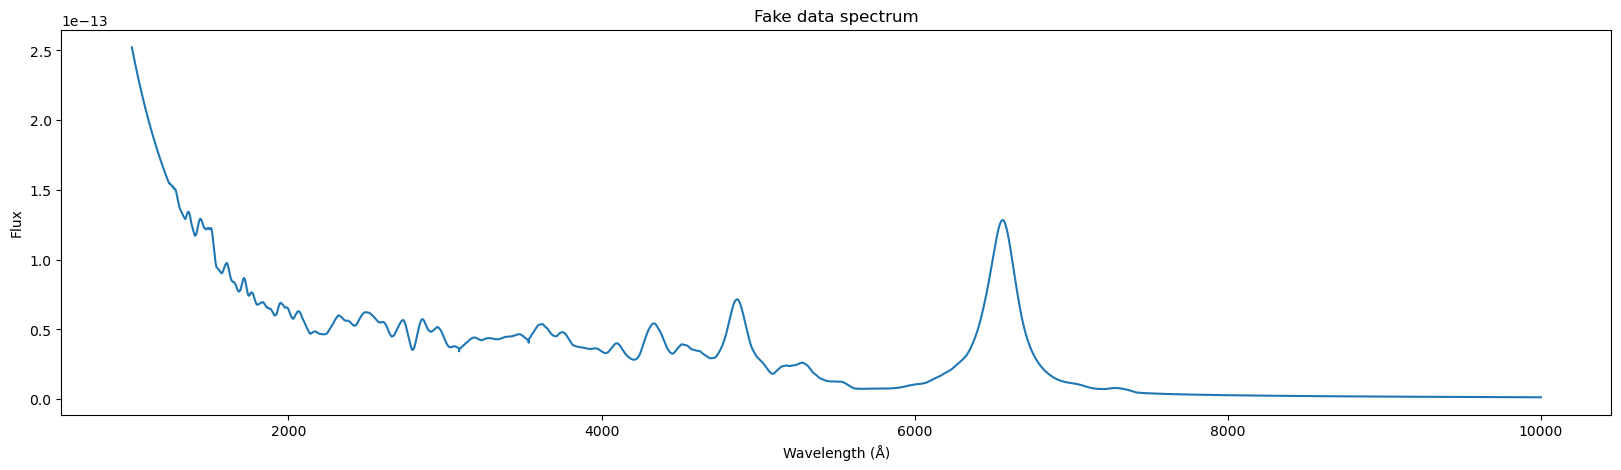

In [7]:
components=["PL", "BC", "FE"]
comp_params={"PL": NC_PARAMS, "BC": BC_PARAMS, "FE": FE_PARAMS} # , "BC": BC_PARAMS, "HOST": HG_PARAMS
#comp_params={"PL": NC_PARAMS, "BC": BC_PARAMS} # , "BC": BC_PARAMS, "HOST": HG_PARAMS
#comp_params={"HOST": HG_PARAMS} # , "BC": BC_PARAMS, "HOST": HG_PARAMS
# "HOST": HG_PARAMS

wl, flux, flux_err, all_fluxes, comp_names = generate_data(components=components, comp_params=comp_params)
print(len(all_fluxes))
print(comp_names)
fig = plt.figure(figsize=(20,5))
plt.plot(wl, flux)
plt.title(f"Fake data spectrum")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
#plt.plot(wl, all_fluxes[3])

In [8]:
spamm(comp_names, (wl, flux, flux_err), comp_params=comp_params,
      n_walkers=32, n_iterations=500,
      outdir="combined_test", picklefile="combined", parallel=True)

Adding wl to comp_params.

Adding flux to comp_params.

Adding err to comp_params.

Adding components to comp_params.



100%|█████████████████████████████████████████| 500/500 [09:13<00:00,  1.11s/it]


Mean acceptance fraction: 0.348
Saved pickle file combined_test/combined.pickle.gz
Plotting the sample projections.
	Saved combined_triangle.png
Plotting the MCMC chains.
	Saved combined_chain.png
Plotting the model posterior PDFs.
	Saved combined_posterior.png
Saved combined_test/combined_posterior.pdf
executed in 0:09:20.636005


{'model': <spamm.Model.Model at 0x1366b7f50>,
 'comp_params': {'PL': {'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5]),
   'slope1': 2.3,
   'norm_PL': 5e-15,
   'broken_pl': False},
  'BC': {'bc_norm': 3e-14,
   'bc_tauBE': 1.0,
   'bc_logNe': 5.5,
   'bc_loffset': 0.0,
   'bc_lwidth': 5050.0,
   'bc_Te': 50250.0,
   'bc_lines': 201.5,
   'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])},
  'FE': {'fe_norm_1': 1.07988504e-14,
   'fe_norm_2': 6.91877436e-15,
   'fe_norm_3': 5e-15,
   'fe_width': 5450,
   'no_templates': 3,
   'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])},
  'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5]),
  'flux': array([2.52280864e-13, 2.51991246e-13, 2.51702105e-13, ...,
         1.41900366e-15, 1.41881671e-15, 1.41862981e-15]),
  'err': array([1.26103984e-14, 1.25959084e-14, 1.25814423e-14, ...,
         6.36939100e-17, 6.36864407e-17, 6.36789726e-17]),
  'components': {'PL': True,
   'FE'

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
#fig = plt.figure(figsize=(20,5))
#plt.plot(wl, flux)

S = Samples("combined_test/combined.pickle.gz")

In [10]:
plot_best_models(S)

	Saved {}_best.png
